In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import calendar

# Benchmark Processing

Benchmarks are confirmed to be Li2CO3 and LiOH from Wind Database

In [2]:
def wind_process(df):
    df.set_index('Date', inplace = True)
    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df.index = pd.to_datetime(df.index)
    df['Price'].replace(0, np.NaN, inplace = True)
    return df

# def str_to_num(s):
#     s = str(s).replace(',', '')
#     return float(s)

# def investing_process(df): # investing.com processing
#     df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
#     df.set_index('Date', inplace = True)
#     df.sort_index(ascending=True, inplace = True)
#     df['Price'] = df['Price'].apply(str_to_num)
#     df['Price'].replace(0, np.NaN, inplace = True)
#     return df

def get_weekly(df, d): # d: 0-4 for Mon-Fri
    w = df.copy()
    w.rename(columns = {w.columns[0]: 'Price'}, inplace = True)

    # Select one weekday
    w = w[w.index.dayofweek == d]

    w['Prior_Date'] = w.index - datetime.timedelta(days=7) # Get date one week ago
    w['Prior_Price'] = w['Prior_Date'].apply(lambda i: w.loc[i,'Price'] if i in w.index else np.NaN) # Get price one week ago
    w['Weekly_Return'] = np.log(w.Price) - np.log(w.Prior_Price) # Weekly return
    w['Weekly_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)

    w = w.drop(columns = ['Prior_Date','Prior_Price'])
    return w

def zeros(df, freq): # Get daily return and zeros, freq = 'M' for monthly end zeros, 'A' for yearly end zeros

    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
    df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    df['Zeros'] = (df['Daily_Return'] == 0).astype(int)

    if freq == 'M':
        z = df['Zeros'].resample(freq).sum() / 22
    else:
        z = df['Zeros'].resample(freq).sum() / 252
    # z = df['Zeros'].resample(freq).sum() / df[freq].resample('M').size()
    return z.to_frame()

# def get_return(df): # Get weekly return for each day

#     # Rename 'Adj Close' to 'Price'
#     df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)

#     # Weekly return calculate Mon-Mon, Tue-Tue, Wed-Wed, Thu-Thu, Fri-Fri return
#     # SELECTION BY dayofweek IS NEEDED WHEN ANALYZIING Weekly_Return
#     df['Prior_Date'] = df.index - datetime.timedelta(days=7) # Get date one week ago
#     df['Prior_Price'] = df['Prior_Date'].apply(lambda i: df.loc[i,'Price'] if i in df.index else np.NaN) # Get price one week ago
#     df['Weekly_Return'] = np.log(df.Price) - np.log(df.Prior_Price) # Weekly return
#     df['Weekly_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    
#     # Get Daily Return
#     df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
#     df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
#     df['Zeros'] = (df['Daily_Return'] == 0).astype(int)

#     df = df.drop(columns = ['Prior_Date','Prior_Price','Daily_Return'])

# def get_daily(df): # Get Daily Return
#     df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
#     df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
#     df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)

y_all = {
    'li2co3': wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')), # Wind Lithium Carbonate Price
    'lioh': wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')), # Wind Lithium Hydroxide Price
    # 'ltcb': investing_process(pd.read_csv('./Data/99C-LTCB.csv', usecols=[0,1])), # Investing.com Lithium Carbonate (Li2CO3) 99% Min China Spot
    # 'ltmt': investing_process(pd.read_csv('./Data/99MIN-LTMT.csv', usecols=[0,1])) # Investing.com 99% Min China Lithium Metal Spot
}

## Benchmark Zeros
### Monthly Zeros
Around 2014, a lot of days are missing. It has data one or twice a week. Ratios exceed 1 because the denominator is set as 22, one month may include more than 22 days. And in 2017, clusters of data missing.

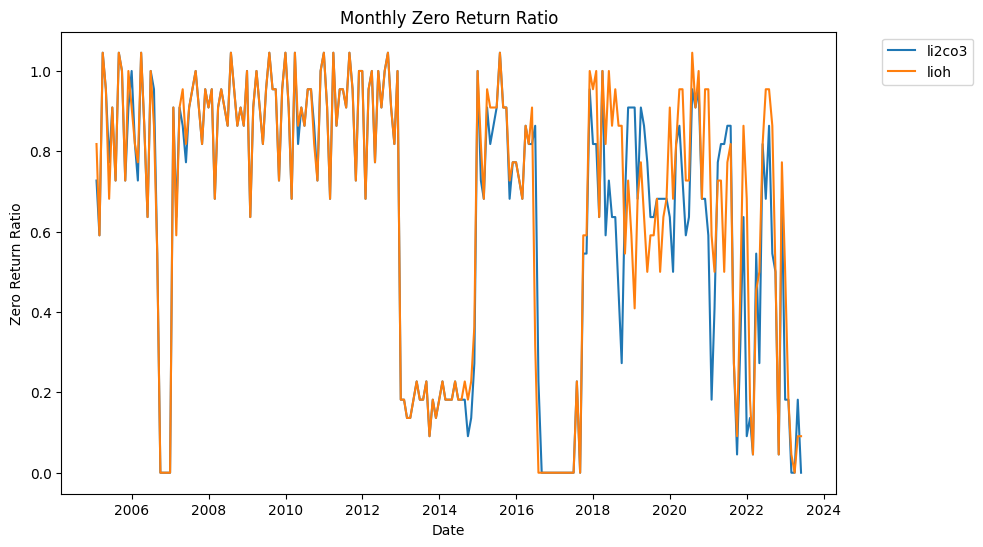

In [3]:
y_zeros_m = {df: zeros(y_all[df], 'M') for df in y_all}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in y_zeros_m:
    plt.plot(y_zeros_m[df], label = df)

plt.title('Monthly Zero Return Ratio')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Yearly Zeros Table

In [4]:
y_zeros_y = {df: zeros(y_all[df],'A') for df in y_all}

zeros_table = pd.DataFrame(index = y_zeros_y['li2co3'].index)
for df in y_zeros_y:
    zeros_table = pd.merge(zeros_table, y_zeros_y[df].loc[:,'Zeros'], how='left', left_index=True, right_index=True, suffixes=(None,f'_{df}'))
zeros_table.rename(columns = {'Zeros':'Zeros_li2co3'}, inplace=True)
display(zeros_table)

,Zeros_li2co3,Zeros_lioh
Date,,
2005-12-31,0.908730,0.908730
2006-12-31,0.575397,0.571429
2007-12-31,0.920635,0.928571
2008-12-31,0.952381,0.952381
2009-12-31,0.952381,0.952381
2010-12-31,0.940476,0.940476
2011-12-31,0.964286,0.964286
2012-12-31,0.896825,0.896825
2013-12-31,0.178571,0.178571


## Benchmark Weekly Return

In [5]:
for i in range(5):
    for df in y_all:
        globals()[f'y_{i}'] = {df: get_weekly(y_all[df],i) for df in y_all}

# Time Series Task 1

## Import Data from yahoo finance
See Upstream_companies.csv for stock details.

In [6]:
upstream = pd.read_csv('./Data/Upstream_companies.csv').iloc[:,1:] # first col is index
stock_currency = upstream.set_index('Stock')

# Select only from 2017 to 2023
start_date = '2017-09-08'
end_date = '2023-05-22'
up_price = {}
for s in stock_currency.index:
    up_price[s] = yf.download(s, start = start_date, end = end_date, interval='1d')['Adj Close'].to_frame()

    # Get currency of each stock
    currency_str = stock_currency.loc[s,'Currency']
    currency_converter = currency_str + 'CNY=X'

    # Get currency time seires and adjust Close price
    if currency_converter != 'CNYCNY=X':
        currency = yf.download(currency_converter, start = start_date, end = end_date, interval='1d')['Adj Close'].to_frame()
        up_price[s] = up_price[s].merge(currency, how='left', left_index=True, right_index=True, suffixes=(None,f'_cur'))
        up_price[s]['Adj Close_CNY'] = up_price[s]['Adj Close'] * up_price[s]['Adj Close_cur']
        up_price[s].drop(columns = ['Adj Close', 'Adj Close_cur'], inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Get mean and standard deviation for Mon-Mon, Tue-Tue, Wed-Wed, Thu-Thu, Fri-Fri

Result does not take currency and time zone into account

In [7]:
for i in range(5):
    globals()['x_' + str(i)] = {df: get_weekly(up_price[df],i) for df in up_price}
    # coampanies can be checked in dictionary for each weekday: x_0, x_1, x_2, x_3, x_4

def week_mean_std(i): # i: 0-4 for weekdays
    upstream[f'{calendar.day_abbr[i]}_Mean'] = upstream['Stock'].apply(lambda m: globals()[f'x_{i}'][m]['Weekly_Return'].mean())
    upstream[f'{calendar.day_abbr[i]}_Std'] = upstream['Stock'].apply(lambda m: globals()[f'x_{i}'][m]['Weekly_Return'].std())

for i in range(5):
    week_mean_std(i)

display(upstream)

,Name,Stock,Exchange,Currency,Time Zone,Market Cap,Mon_Mean,Mon_Std,Tue_Mean,Tue_Std,Wed_Mean,Wed_Std,Thu_Mean,Thu_Std,Fri_Mean,Fri_Std
0,Jiangxi Special Electric Motor,002176.SZ,SHZ,CNY,CST,19213.275136,0.002781,0.081636,0.002303,0.082618,-0.001138,0.081351,0.000209,0.083446,0.000160,0.083017
1,Ganfeng Lithium,002460.SZ,SHZ,CNY,CST,110657.830912,0.001341,0.077300,0.001591,0.073228,0.001461,0.069444,0.001286,0.069500,-0.001229,0.070807
2,Tianqi Lithium,002466.SZ,SHZ,CNY,CST,95878.569984,0.002294,0.090766,0.002005,0.088512,0.000283,0.084342,0.003359,0.082566,0.001527,0.081943
3,Sichuan Yahua Group,002497.SZ,SHZ,CNY,CST,20699.975680,0.001953,0.075384,0.000963,0.075827,-0.001811,0.073186,-0.001130,0.070312,-0.002484,0.073102
4,Allkem Limited,AKE.AX,ASX,AUD,AEST,9067.496448,0.007185,0.089242,0.003980,0.082597,0.004614,0.079687,0.004081,0.087236,0.003496,0.084111
5,Albemarle,ALB,NYQ,USD,EDT,22788.997120,0.001848,0.060889,0.002353,0.060246,0.002574,0.063750,0.002782,0.070435,0.001614,0.065400
6,Atlantic Lithium,ALL.L,LSE,GBp,BST,125.040856,-0.001470,0.102864,-0.001444,0.095519,-0.000720,0.097687,-0.000425,0.095150,0.000547,0.097569
7,American Lithium,AMLI,NCM,USD,EDT,306.956640,0.007445,0.155333,0.008726,0.134610,0.004897,0.143154,0.010854,0.148273,0.006419,0.141886
8,Critical Elements Lithium Corporation,CRE.V,VAN,CAD,EDT,363.700928,-0.003989,0.105550,0.000458,0.099908,0.000645,0.102931,0.000410,0.097319,0.001932,0.091634
9,Eramet SA,ERA.PA,PAR,EUR,CEST,2222.308864,0.000530,0.086704,0.000215,0.084538,0.002023,0.081513,0.001124,0.084829,0.001055,0.083280


## First Order Autocorrelation

In [8]:
def plot_autocorr(i): # i: 0-4 for x_0, x_1, x_2, x_3, x_4
    for df in globals()[f'x_{i}']:
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        plot_acf(globals()[f'x_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, title = f'{df}_{calendar.day_abbr[i]} Autocorrelation', ax=ax[0])
        plot_pacf(globals()[f'x_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, method = 'ols', title = f'{df}_{calendar.day_abbr[i]} Partial Autocorrelation', ax=ax[1])
        plt.show()

# for i in range(5):
#     plot_autocorr(i)

## Zeros

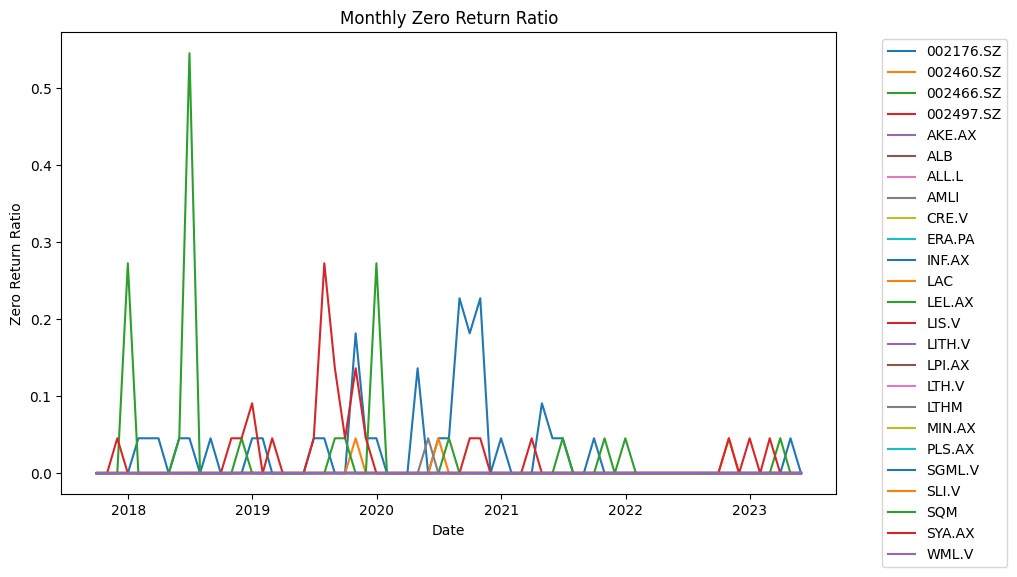

In [9]:
up_zeros = {df: zeros(up_price[df],'M') for df in up_price}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in up_zeros:
    plt.plot(up_zeros[df], label = df)

plt.title('Monthly Zero Return Ratio')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Time Series Task 2

### Part 1

In [10]:
# Merge Data
for i in range(5):
    for ydf in globals()[f'y_{i}']:
        for xdf in globals()[f'x_{i}']:
            globals()[f'y_{i}'][ydf] = globals()[f'y_{i}'][ydf].merge(globals()[f'x_{i}'][xdf]['Weekly_Return'], how='right', left_index=True, right_index=True, suffixes=(None,f'_{xdf}'))
        globals()[f'y_{i}'][ydf].drop(columns = ['Price','Daily_Return','Zeros'], inplace=True, errors='ignore')

In [14]:
# model = smf.ols('Li_LogRetur ~ Assest_LogReturn', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
y_4['li2co3'].columns.to_list()[1]
# formula = y_4['li2co3'].columns.to_list()[0] + '~' + y_4['li2co3'].columns.to_list()[1]
# print(formula)
# model = smf.ols(formula, data=y_4['li2co3']).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
# model.summary()
e = y_4['li2co3'].copy()
e.dropna(inplace=True)

Y = e['Weekly_Return']
X = e['Weekly_Return_AKE.AX']
X = sm.add_constant(X)

model = sm.OLS(Y,X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
# res_dict = {'constant':model.params['const'],
#     'intercept_pvalue' : model.pvalues['const'],
#     'coefficient' : model.params['Weekly_Return_AKE.AX'],
#     'coefficient_pvalue' : model.pvalues['Weekly_Return_AKE.AX'],
#     'hac_standard_error' : model.bse['Weekly_Return_AKE.AX']}
# res_dict
model.params['Weekly_Return_AKE.AX']


0.11714522906886603

In [22]:
def reg_res(df): # Get regression result from df, e.g y_4['lioh']
    temp = df.copy()
    temp.dropna(inplace=True)
    Y = temp['Weekly_Return']
    stock_list = upstream.Stock.tolist()
    
    res_df = pd.DataFrame(index = ['constant', 'constant_pvalues', 'coefficient', 'coefficient_pvalue', 'hac_standard_error'])
    for s in stock_list:
        col = 'Weekly_Return_' + s
        X = temp[col]
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # Order: constant, constant_pvalues, coefficient, coefficient_pvalue, hac_standard_error
        res_df[s] = [model.params['const'], model.pvalues['const'], model.params[col], \
            model.pvalues[col], model.bse[col]]
    return res_df.transpose()

for i in range(5):
    for df in globals()[f'y_{i}']:
        print(df + f'_{i}')
        display(reg_res(globals()[f'y_{i}'][df]))


li2co3_0


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,-0.001084,0.936422,0.071569,0.204438,0.056398
002460.SZ,-0.001500,0.912997,-0.045692,0.596908,0.086398
002466.SZ,-0.001147,0.933960,-0.009478,0.869813,0.057828
002497.SZ,-0.000202,0.988123,0.052943,0.494808,0.077551
AKE.AX,-0.001072,0.937608,-0.003679,0.971603,0.103344
ALB,-0.001158,0.933218,0.046822,0.668478,0.109337
ALL.L,-0.001048,0.939526,0.010629,0.846198,0.054796
AMLI,-0.001205,0.932729,0.009999,0.843179,0.050545
CRE.V,-0.001475,0.912309,-0.047170,0.571274,0.083313
ERA.PA,-0.002589,0.854568,0.100796,0.314556,0.100224


lioh_0


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,-0.000871,0.935552,0.126660,0.116410,0.080674
002460.SZ,-0.001095,0.921080,-0.020884,0.711301,0.056427
002466.SZ,-0.000820,0.941184,0.025012,0.546113,0.041439
002497.SZ,0.000243,0.982074,0.067606,0.394643,0.079421
AKE.AX,-0.001044,0.921935,0.012076,0.872118,0.075021
ALB,-0.001043,0.924223,0.123999,0.246751,0.107054
ALL.L,-0.000776,0.944498,0.023894,0.345322,0.025319
AMLI,-0.001225,0.914955,0.032629,0.427256,0.041099
CRE.V,-0.001478,0.895077,-0.072635,0.335213,0.075374
ERA.PA,-0.003624,0.747282,0.184600,0.128650,0.121491


li2co3_1


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.007064,0.489661,0.126474,0.065982,0.068790
002460.SZ,0.008290,0.416495,0.118358,0.205552,0.093498
002466.SZ,0.007675,0.456837,0.100439,0.183270,0.075475
002497.SZ,0.007720,0.421918,0.231388,0.012854,0.093009
AKE.AX,0.008118,0.435386,0.069832,0.446322,0.091696
ALB,0.008537,0.410427,0.045972,0.667059,0.106866
ALL.L,0.008582,0.402472,0.016893,0.763342,0.056104
AMLI,0.008593,0.404907,0.004474,0.933398,0.053535
CRE.V,0.008574,0.401844,-0.019430,0.720880,0.054381
ERA.PA,0.008346,0.417289,0.039497,0.482562,0.056249


lioh_1


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.008664,0.304129,0.125681,0.033010,0.058951
002460.SZ,0.010003,0.247011,0.071399,0.349639,0.076339
002466.SZ,0.009710,0.267371,0.052151,0.384249,0.059937
002497.SZ,0.009474,0.245240,0.188215,0.013745,0.076391
AKE.AX,0.010018,0.257222,0.024943,0.711615,0.067471
ALB,0.010174,0.248052,0.012115,0.904079,0.100527
ALL.L,0.010218,0.242591,-0.025146,0.662465,0.057606
AMLI,0.010235,0.240904,-0.026074,0.539031,0.042446
CRE.V,0.010210,0.238643,0.014609,0.777030,0.051588
ERA.PA,0.009977,0.236373,0.033148,0.644547,0.071849


li2co3_2


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.012864,0.144316,0.053939,0.244131,0.046310
002460.SZ,0.013131,0.138056,0.042639,0.563192,0.073757
002466.SZ,0.012866,0.146897,0.053408,0.316715,0.053342
002497.SZ,0.013325,0.119210,0.151316,0.043553,0.074970
AKE.AX,0.011916,0.173941,0.126289,0.086357,0.073640
ALB,0.012858,0.148816,0.057549,0.542431,0.094476
ALL.L,0.012939,0.146066,-0.002854,0.940801,0.038435
AMLI,0.012940,0.142825,0.007648,0.868107,0.046057
CRE.V,0.013134,0.143665,-0.055110,0.449924,0.072941
ERA.PA,0.012751,0.148041,0.045818,0.336753,0.047698


lioh_2


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.013126,0.101107,0.078340,0.188881,0.059624
002460.SZ,0.013458,0.098609,0.050599,0.512746,0.077302
002466.SZ,0.013142,0.106456,0.064661,0.328331,0.066150
002497.SZ,0.013632,0.078825,0.158292,0.046611,0.079551
AKE.AX,0.012241,0.124307,0.121692,0.119086,0.078077
ALB,0.013142,0.109584,0.061456,0.612301,0.121264
ALL.L,0.013319,0.101719,-0.018912,0.660018,0.042993
AMLI,0.013180,0.102892,-0.013440,0.749671,0.042123
CRE.V,0.013381,0.102584,-0.044554,0.521090,0.069435
ERA.PA,0.012805,0.100440,0.108438,0.059003,0.057430


li2co3_3


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.011493,0.316076,0.055517,0.314243,0.055166
002460.SZ,0.011677,0.311266,0.065237,0.528319,0.103457
002466.SZ,0.011167,0.333563,0.048596,0.527291,0.076874
002497.SZ,0.012226,0.275651,0.182965,0.031464,0.085054
AKE.AX,0.010258,0.370883,0.104500,0.237536,0.088472
ALB,0.011220,0.330060,0.105940,0.380983,0.120924
ALL.L,0.011366,0.322978,0.032040,0.490416,0.046458
AMLI,0.011428,0.321967,0.022814,0.584952,0.041771
CRE.V,0.011512,0.323763,-0.023458,0.693817,0.059585
ERA.PA,0.011364,0.321096,0.074585,0.147576,0.051504


lioh_3


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.011114,0.288291,0.080182,0.196596,0.062093
002460.SZ,0.011080,0.301428,0.010086,0.918366,0.098403
002466.SZ,0.010774,0.312956,0.047319,0.545822,0.078338
002497.SZ,0.011884,0.245959,0.196511,0.032840,0.092084
AKE.AX,0.010615,0.319919,0.037768,0.476430,0.053040
ALB,0.010922,0.308320,0.057664,0.582879,0.104999
ALL.L,0.011057,0.298279,-0.005307,0.916464,0.050601
AMLI,0.011055,0.300411,-0.016337,0.672633,0.038664
CRE.V,0.011189,0.298993,-0.050241,0.461232,0.068186
ERA.PA,0.010926,0.295592,0.110404,0.083386,0.063767


li2co3_4


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.013238,0.206172,0.049936,0.310815,0.049270
002460.SZ,0.013454,0.198360,0.009926,0.906486,0.084496
002466.SZ,0.013426,0.203220,0.002494,0.973364,0.074706
002497.SZ,0.013956,0.176660,0.107218,0.139772,0.072610
AKE.AX,0.012151,0.227581,0.117145,0.291280,0.111005
ALB,0.013108,0.217288,0.048334,0.628800,0.099984
ALL.L,0.013238,0.204486,0.030306,0.491555,0.044060
AMLI,0.013373,0.205086,0.011030,0.774227,0.038453
CRE.V,0.013690,0.193542,-0.056752,0.260283,0.050414
ERA.PA,0.013096,0.210963,0.041351,0.329000,0.042362


lioh_4


,constant,constant_pvalues,coefficient,coefficient_pvalue,hac_standard_error
002176.SZ,0.012531,0.149356,0.091277,0.082442,0.052558
002460.SZ,0.012994,0.138444,0.055322,0.455556,0.074139
002466.SZ,0.012719,0.150293,0.049396,0.471247,0.068562
002497.SZ,0.013676,0.107095,0.161488,0.032884,0.075692
AKE.AX,0.012184,0.157732,0.064480,0.397207,0.076162
ALB,0.012470,0.174198,0.062256,0.550331,0.104236
ALL.L,0.012747,0.147861,0.022254,0.488657,0.032138
AMLI,0.012961,0.146420,-0.012408,0.694101,0.031550
CRE.V,0.013056,0.136995,-0.036709,0.421435,0.045661
ERA.PA,0.012216,0.157453,0.082234,0.043902,0.040810


In [13]:
tup = (1,3,4,6,4)
ind = ('a','b','c','d','e')
dfx = pd.DataFrame(index = ind)
dfx['hello'] = tup
dfx.transpose()

,a,b,c,d,e
hello,1,3,4,6,4
